In [ ]:
import pandas as pd
import numpy as np
import string

In [ ]:
lines= pd.read_table('english to french.txt', names=['eng', 'fr'])

In [ ]:
lines = lines[0:50000]
print(lines.head(3))
print(lines.tail(3))

    eng        fr
0   Go.      Va !
1  Run!   Cours !
2  Run!  Courez !
                            eng                              fr
49997  They go to work on foot.     Ils vont au travail à pied.
49998  They got into the train.    Ils montèrent dans le train.
49999  They got into the train.  Elles montèrent dans le train.


In [ ]:
lines['eng']=lines['eng'].apply(lambda x: x.lower())
lines['fr']=lines['fr'].apply(lambda x: x.lower())

In [ ]:
exclude = set(string.punctuation)
lines.eng=lines.eng.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines.fr=lines.fr.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [ ]:
print(lines.head(3))
print(lines.tail(3))

   eng       fr
0   go      va 
1  run   cours 
2  run  courez 
                           eng                             fr
49997  they go to work on foot     ils vont au travail à pied
49998  they got into the train    ils montèrent dans le train
49999  they got into the train  elles montèrent dans le train


In [ ]:
lines.fr = lines.fr.apply(lambda x : 'start '+ x + ' end')

In [ ]:
print(lines.head(3))
print(lines.tail(3))

   eng                 fr
0   go      start va  end
1  run   start cours  end
2  run  start courez  end
                           eng                                       fr
49997  they go to work on foot     start ils vont au travail à pied end
49998  they got into the train    start ils montèrent dans le train end
49999  they got into the train  start elles montèrent dans le train end


In [ ]:
lines.shape

(50000, 2)

In [ ]:
# fit a tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [ ]:
import json
eng_tokenizer = create_tokenizer(lines['eng'])
eng_dict=json.loads(json.dumps(eng_tokenizer.word_counts))
df =pd.DataFrame([eng_dict.keys(), eng_dict.values()]).T
df.columns = ['word','count']
print(df.head())
df = df.sort_values(by='count',ascending = False)
df['cum_count']=df['count'].cumsum()
df['cum_perc'] = df['cum_count']/df['cum_count'].max()
final_eng_words = df[df['cum_perc']<0.8]['word'].values
print(final_eng_words[:10])

   word count
0    go  1155
1   run    88
2   wow     5
3  fire    49
4  help   433
['i' 'you' 'a' 'is' 'the' 'it' 'to' 'he' 'tom' 'im']


In [ ]:
fr_tokenizer = create_tokenizer(lines['fr'])
fr_dict = json.loads(json.dumps(fr_tokenizer.word_counts))
df =pd.DataFrame([fr_dict.keys(), fr_dict.values()]).T
df.columns = ['word','count']
df = df.sort_values(by='count',ascending = False)
df['cum_count']=df['count'].cumsum()
df['cum_perc'] = df['cum_count']/df['cum_count'].max()
final_fr_words = df[df['cum_perc']<0.8]['word'].values
print(final_fr_words[:10])

['start' 'end' 'je' 'pas' 'de' 'ne' 'vous' 'il' 'le' 'est']


In [ ]:
print(len(final_eng_words),len(final_fr_words))

384 357


In [ ]:
def filter_eng_words(x):
  t = []
  x = x.split()
  for i in range(len(x)):
    if x[i] in final_eng_words:
      t.append(x[i])
    else:
      t.append('unk')
  x3 = ''
  for i in range(len(t)):
    x3 = x3+t[i]+' '
  return x3

In [ ]:
filter_eng_words('he is extremely good')

'he is unk good '

In [ ]:
def filter_fr_words(x):
  t = []
  x = x.split()
  for i in range(len(x)):
    if x[i] in final_fr_words:
      t.append(x[i])
    else:
      t.append('unk')
  x3 = ''
  for i in range(len(t)):
    x3 = x3+t[i]+' '
  return x3

In [ ]:
lines['eng']=lines['eng'].apply(filter_eng_words)

In [ ]:
lines['fr']=lines['fr'].apply(filter_fr_words)

In [ ]:
all_eng_words=set()
for eng in lines.eng:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)
    
all_french_words=set()
for fr in lines.fr:
    for word in fr.split():
        if word not in all_french_words:
            all_french_words.add(word)

In [ ]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_french_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_french_words)
# del all_eng_words, all_french_words

In [ ]:
set(all_french_words) - set(final_fr_words) 

{'unk'}

In [ ]:
len(all_eng_words)

385

In [ ]:
len(target_words)

358

In [ ]:
input_token_index = dict(
    [(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict(
    [(word, i+1) for i, word in enumerate(target_words)])

In [ ]:
num_decoder_tokens

358

In [ ]:
print(input_token_index['unk'])
print(target_token_index['start'])
print(target_token_index['end'])
print(list(input_token_index.keys())[335])
print(list(target_token_index.keys())[283])
print(list(target_token_index.keys())[88])

336
284
89
unk
start
end


In [ ]:
length_list=[]
for l in lines.fr:
    length_list.append(len(l.split(' ')))
fr_max_length = np.max(length_list)

In [ ]:
length_list=[]
for l in lines.eng:
    length_list.append(len(l.split(' ')))
eng_max_length = np.max(length_list)

In [ ]:
print(eng_max_length)
print(fr_max_length)

8
17


In [ ]:
encoder_input_data = np.zeros(
    (len(lines['eng']), eng_max_length),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(lines['fr']), fr_max_length),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(lines['fr']), fr_max_length, num_decoder_tokens+1),
    dtype='float32')

In [ ]:
decoder_target_data.shape

(50000, 17, 359)

In [ ]:
for i, (input_text, target_text) in enumerate(zip(lines['eng'], lines['fr'])):
    for t, word in enumerate(input_text.split()):
        encoder_input_data[i, t] = input_token_index[word]
    for t, word in enumerate(target_text.split()):
        decoder_input_data[i, t] = target_token_index[word]
        if t>0:
            decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            if t== len(target_text.split())-1:
                decoder_target_data[i, t:, 89] = 1

In [ ]:
print(decoder_input_data.shape,encoder_input_data.shape,decoder_target_data.shape)

(50000, 17) (50000, 8) (50000, 17, 359)


In [ ]:
print(decoder_input_data[:3])

[[284. 321.  89.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.]
 [284. 320.  89.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.]
 [284. 320.  89.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.]]


In [ ]:
for i in range(decoder_input_data.shape[0]):
    for j in range(decoder_input_data.shape[1]):
        if(decoder_input_data[i][j]==0):
            decoder_input_data[i][j] = 89

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Bidirectional, RepeatVector, Dropout
model1 = Sequential()
model1.add(Embedding(len(input_words)+1, 128, input_length=eng_max_length))#input_words=385
model1.add(Bidirectional(LSTM(256)))
model1.add(RepeatVector(fr_max_length))
model1.add((LSTM(256, return_sequences=True)))
model1.add((Dense(len(target_token_index)+1, activation='softmax')))
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 8, 128)            49408     
_________________________________________________________________
bidirectional (Bidirectional (None, 512)               788480    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 17, 512)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 17, 256)           787456    
_________________________________________________________________
dense (Dense)                (None, 17, 359)           92263     
Total params: 1,717,607
Trainable params: 1,717,607
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model1.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc'])

In [ ]:
history = model1.fit(encoder_input_data, decoder_target_data,
          batch_size=128,
          epochs=5,
          validation_split=0.05)

Epoch 1/5
372/372 [==============================] - 50s 126ms/step - loss: 1.5763 - acc: 0.7655 - val_loss: 1.2745 - val_acc: 0.7600
Epoch 2/5
372/372 [==============================] - 49s 130ms/step - loss: 0.9570 - acc: 0.8118 - val_loss: 1.1540 - val_acc: 0.7704
Epoch 3/5
372/372 [==============================] - 52s 141ms/step - loss: 0.8209 - acc: 0.8292 - val_loss: 1.0540 - val_acc: 0.7834
Epoch 4/5
372/372 [==============================] - 64s 173ms/step - loss: 0.7279 - acc: 0.8418 - val_loss: 0.9773 - val_acc: 0.7899
Epoch 5/5
372/372 [==============================] - 60s 162ms/step - loss: 0.6574 - acc: 0.8502 - val_loss: 0.9059 - val_acc: 0.7994


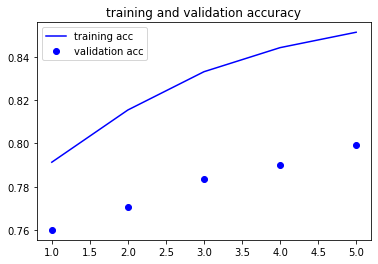

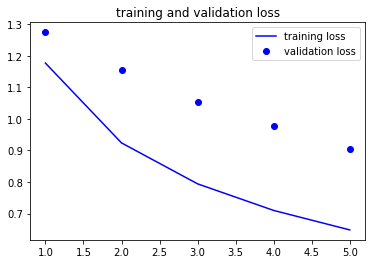

In [ ]:
import matplotlib.pyplot as plt
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'b',label='training acc')
plt.plot(epochs,val_acc,'bo',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'b',label='training loss')
plt.plot(epochs,val_loss,'bo',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()


In [ ]:
count = 0
correct_count = 0
pred = model1.predict(encoder_input_data[47500:])
for i in range(2500):
    t = np.argmax(pred[i], axis=-1)
    act=np.argmax(decoder_target_data[47500+i], axis=-1)
    correct_count += np.sum((act==t) & (act!=89))
    count += np.sum(act!=89)
print(correct_count, count)
print(correct_count/count)

5230 13426
0.3895426783852227


In [ ]:
encoder_input_data[-2400]

array([155.,  98., 185., 336.,   0.,   0.,   0.,   0.], dtype=float32)

In [ ]:
t = model1.predict(encoder_input_data[-2400].reshape(1,encoder_input_data.shape[1])).reshape(decoder_input_data.shape[1], num_decoder_tokens+1)
t2 = np.argmax(t,axis=1)
for i in range(len(t2)):
  if int(t2[i])!=0:
    print(list(target_token_index.keys())[int(t2[i]-1)])
    if int(t2[i])==89:
        break


je
me
unk
unk
unk
end


In [ ]:
import pandas as pd
import numpy as np
import string

In [ ]:
lines= pd.read_table('C:/Users/user/Desktop/딥러닝교재/제 12장 머신번역(n)/english to french/english to french.txt', names=['eng', 'fr'])


In [ ]:
lines = lines[0:50000]
print(lines.head(3))
print(lines.tail(3))

    eng        fr
0   Go.      Va !
1  Run!   Cours !
2  Run!  Courez !
                            eng                              fr
49997  They go to work on foot.     Ils vont au travail à pied.
49998  They got into the train.    Ils montèrent dans le train.
49999  They got into the train.  Elles montèrent dans le train.


In [ ]:
lines['eng']=lines['eng'].apply(lambda x: x.lower())
lines['fr']=lines['fr'].apply(lambda x: x.lower())

In [ ]:
exclude = set(string.punctuation)
lines.eng=lines.eng.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines.fr=lines.fr.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [ ]:
print(lines.head(3))
print(lines.tail(3))

   eng       fr
0   go      va 
1  run   cours 
2  run  courez 
                           eng                             fr
49997  they go to work on foot     ils vont au travail à pied
49998  they got into the train    ils montèrent dans le train
49999  they got into the train  elles montèrent dans le train


In [ ]:
lines.fr = lines.fr.apply(lambda x : 'start '+ x + ' end')

In [ ]:
print(lines.head(3))
print(lines.tail(3))

   eng                 fr
0   go      start va  end
1  run   start cours  end
2  run  start courez  end
                           eng                                       fr
49997  they go to work on foot     start ils vont au travail à pied end
49998  they got into the train    start ils montèrent dans le train end
49999  they got into the train  start elles montèrent dans le train end


In [ ]:
lines.shape

(50000, 2)

In [ ]:
# fit a tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [ ]:
import json
eng_tokenizer = create_tokenizer(lines['eng'])
eng_dict=json.loads(json.dumps(eng_tokenizer.word_counts))
df =pd.DataFrame([eng_dict.keys(), eng_dict.values()]).T
df.columns = ['word','count']
df = df.sort_values(by='count',ascending = False)
df['cum_count']=df['count'].cumsum()
df['cum_perc'] = df['cum_count']/df['cum_count'].max()
final_eng_words = df[df['cum_perc']<0.8]['word'].values

In [ ]:
fr_tokenizer = create_tokenizer(lines['fr'])
fr_dict = json.loads(json.dumps(fr_tokenizer.word_counts))
df =pd.DataFrame([fr_dict.keys(), fr_dict.values()]).T
df.columns = ['word','count']
df = df.sort_values(by='count',ascending = False)
df['cum_count']=df['count'].cumsum()
df['cum_perc'] = df['cum_count']/df['cum_count'].max()
final_fr_words = df[df['cum_perc']<0.8]['word'].values

In [ ]:
print(len(final_eng_words),len(final_fr_words))

384 357


In [ ]:
def filter_eng_words(x):
  t = []
  x = x.split()
  for i in range(len(x)):
    if x[i] in final_eng_words:
      t.append(x[i])
    else:
      t.append('unk')
  x3 = ''
  for i in range(len(t)):
    x3 = x3+t[i]+' '
  return x3

In [ ]:
filter_eng_words('he is extremely good')

'he is unk good '

In [ ]:
def filter_fr_words(x):
  t = []
  x = x.split()
  for i in range(len(x)):
    if x[i] in final_fr_words:
      t.append(x[i])
    else:
      t.append('unk')
  x3 = ''
  for i in range(len(t)):
    x3 = x3+t[i]+' '
  return x3

In [ ]:
lines['eng']=lines['eng'].apply(filter_eng_words)

In [ ]:
lines['fr']=lines['fr'].apply(filter_fr_words)

In [ ]:
all_eng_words=set()
for eng in lines.eng:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)
    
all_french_words=set()
for fr in lines.fr:
    for word in fr.split():
        if word not in all_french_words:
            all_french_words.add(word)

In [ ]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_french_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_french_words)
# del all_eng_words, all_french_words

In [ ]:
set(all_french_words) - set(final_fr_words) 

{'unk'}

In [ ]:
len(all_eng_words)

385

In [ ]:
len(target_words)

358

In [ ]:
input_token_index = dict(
    [(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict(
    [(word, i+1) for i, word in enumerate(target_words)])

In [ ]:
num_decoder_tokens

358

In [ ]:
print(input_token_index['unk'])
print(target_token_index['start'])
print(target_token_index['end'])
print(list(input_token_index.keys())[335])
print(list(target_token_index.keys())[283])
print(list(target_token_index.keys())[88])

336
284
89
unk
start
end


In [ ]:
length_list=[]
for l in lines.fr:
    length_list.append(len(l.split(' ')))
fr_max_length = np.max(length_list)

In [ ]:
length_list=[]
for l in lines.eng:
    length_list.append(len(l.split(' ')))
eng_max_length = np.max(length_list)

In [ ]:
print(eng_max_length)
print(fr_max_length)

8
17


In [ ]:
encoder_input_data = np.zeros(
    (len(lines['eng']), eng_max_length),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(lines['fr']), fr_max_length),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(lines['fr']), fr_max_length, num_decoder_tokens+1),
    dtype='float32')

In [ ]:
decoder_target_data.shape

(50000, 17, 359)

In [ ]:
for i, (input_text, target_text) in enumerate(zip(lines['eng'], lines['fr'])):
    for t, word in enumerate(input_text.split()):
        encoder_input_data[i, t] = input_token_index[word]
    for t, word in enumerate(target_text.split()):
        decoder_input_data[i, t] = target_token_index[word]
        if t>0:
            decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            if t== len(target_text.split())-1:
                decoder_target_data[i, t:, 89] = 1

In [ ]:
print(decoder_input_data.shape,encoder_input_data.shape,decoder_target_data.shape)

(50000, 17) (50000, 8) (50000, 17, 359)


In [ ]:
for i in range(decoder_input_data.shape[0]):
    for j in range(decoder_input_data.shape[1]):
        if(decoder_input_data[i][j]==0):
            decoder_input_data[i][j] = 89

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Bidirectional, RepeatVector, Dropout
encoder_inputs = Input(shape=(eng_max_length,))
en_x=  Embedding(num_encoder_tokens+1, 128)(encoder_inputs)
encoder = LSTM(256, return_state=True)
encoder_outputs, state_h, state_c = encoder(en_x)
encoder_states = [state_h, state_c]

In [ ]:
decoder_inputs = Input(shape=(fr_max_length,))
dex=  Embedding(num_decoder_tokens+1, 128)(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dex,initial_state=encoder_states)
decoder_outputs = Dense(2000,activation='tanh')(decoder_outputs)
decoder_dense = Dense(num_decoder_tokens+1, activation='softmax')(decoder_outputs)

model2 = Model([encoder_inputs, decoder_inputs], decoder_dense)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 17)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 8, 128)       49408       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 17, 128)      45952       input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
history2 = model2.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=128,
          epochs=5,
          validation_split=0.05)

Epoch 1/5
372/372 [==============================] - 102s 258ms/step - loss: 1.4545 - acc: 0.7765 - val_loss: 1.0526 - val_acc: 0.7884
Epoch 2/5
372/372 [==============================] - 92s 247ms/step - loss: 0.7165 - acc: 0.8502 - val_loss: 0.8364 - val_acc: 0.8138
Epoch 3/5
372/372 [==============================] - 91s 246ms/step - loss: 0.5486 - acc: 0.8723 - val_loss: 0.7001 - val_acc: 0.8319
Epoch 4/5
372/372 [==============================] - 92s 247ms/step - loss: 0.4559 - acc: 0.8866 - val_loss: 0.6269 - val_acc: 0.8449
Epoch 5/5
372/372 [==============================] - 92s 247ms/step - loss: 0.3942 - acc: 0.8975 - val_loss: 0.5868 - val_acc: 0.8515


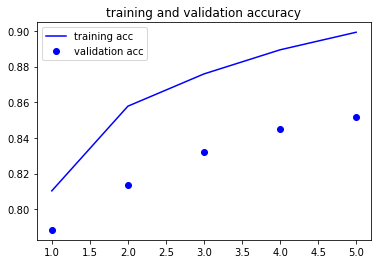

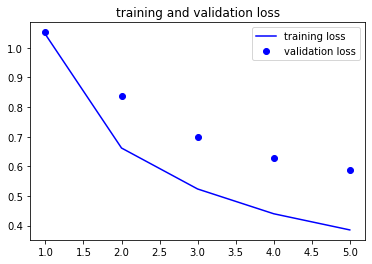

In [ ]:
import matplotlib.pyplot as plt
acc=history2.history['acc']
val_acc=history2.history['val_acc']
loss=history2.history['loss']
val_loss=history2.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'b',label='training acc')
plt.plot(epochs,val_acc,'bo',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'b',label='training loss')
plt.plot(epochs,val_loss,'bo',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

In [ ]:
decoder_target_data.shape

(50000, 17, 359)

In [ ]:
act = np.argmax(decoder_target_data, axis=2)
act.shape

(50000, 17)

In [ ]:
act[5000]

array([134,  83, 320,  89,  89,  89,  89,  89,  89,  89,  89,  89,  89,
        89,  89,  89,  89], dtype=int64)

In [ ]:
count = 0
correct_count = 0
pred = model2.predict([encoder_input_data[47500:],decoder_input_data[47500:]])
for i in range(2500):
  t = np.argmax(pred[i], axis=-1)
  correct_count += np.sum((act[47500+i]==t) & (act[47500+i]!=89))
  count += np.sum(decoder_input_data[47500+i]!=89)
print(correct_count,count)
print(correct_count/count)

7264 15926
0.4561095064674118


In [ ]:
target_token_index['end']

89

In [ ]:
decoder_input_data_pred = np.zeros(
    (len(lines['fr']), fr_max_length),
    dtype='float32')
decoder_input_data_pred.shape

(50000, 17)

In [ ]:
final_pred = []
for i in range(2500):
  word = 284
  for j in range(17):
    decoder_input_data_pred[(47500+i), j] = word
    pred = model2.predict([encoder_input_data[(47500+i)].reshape(1,8),decoder_input_data_pred[47500+i].reshape(1,17)])
    t = np.argmax(pred[0,j])
    word = t
    if word==89:
      break
  final_pred.append(list(decoder_input_data_pred[47500+i]))

In [ ]:
final_pred2 = np.array(final_pred)
final_pred2.shape

(2500, 17)

In [ ]:
count = 0
correct_count = 0

for i in range(2500):
  correct_count += np.sum((decoder_input_data[47500+i]==final_pred2[i]) & (decoder_input_data[47500+i]!=89))
  count += np.sum(decoder_input_data[47500+i]!=89)
correct_count/count

0.4776466155971368

In [ ]:
import pandas as pd
import numpy as np
import string

In [ ]:
lines= pd.read_table('C:/Users/user/Desktop/딥러닝교재/제 12장 머신번역(n)/english to french/english to french.txt', names=['eng', 'fr'])

In [ ]:
lines = lines[0:50000]
print(lines.head(3))
print(lines.tail(3))

    eng        fr
0   Go.      Va !
1  Run!   Cours !
2  Run!  Courez !
                            eng                              fr
49997  They go to work on foot.     Ils vont au travail à pied.
49998  They got into the train.    Ils montèrent dans le train.
49999  They got into the train.  Elles montèrent dans le train.


In [ ]:
lines['eng']=lines['eng'].apply(lambda x: x.lower())
lines['fr']=lines['fr'].apply(lambda x: x.lower())

In [ ]:
exclude = set(string.punctuation)
lines.eng=lines.eng.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines.fr=lines.fr.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [ ]:
print(lines.head(3))
print(lines.tail(3))

   eng       fr
0   go      va 
1  run   cours 
2  run  courez 
                           eng                             fr
49997  they go to work on foot     ils vont au travail à pied
49998  they got into the train    ils montèrent dans le train
49999  they got into the train  elles montèrent dans le train


In [ ]:
lines.fr = lines.fr.apply(lambda x : 'start '+ x + ' end')

In [ ]:
print(lines.head(3))
print(lines.tail(3))

   eng                 fr
0   go      start va  end
1  run   start cours  end
2  run  start courez  end
                           eng                                       fr
49997  they go to work on foot     start ils vont au travail à pied end
49998  they got into the train    start ils montèrent dans le train end
49999  they got into the train  start elles montèrent dans le train end


In [ ]:
lines.shape

(50000, 2)

In [ ]:
# fit a tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [ ]:
import json
eng_tokenizer = create_tokenizer(lines['eng'])
eng_dict=json.loads(json.dumps(eng_tokenizer.word_counts))
df =pd.DataFrame([eng_dict.keys(), eng_dict.values()]).T
df.columns = ['word','count']
df = df.sort_values(by='count',ascending = False)
df['cum_count']=df['count'].cumsum()
df['cum_perc'] = df['cum_count']/df['cum_count'].max()
final_eng_words = df[df['cum_perc']<0.8]['word'].values

In [ ]:
fr_tokenizer = create_tokenizer(lines['fr'])
fr_dict = json.loads(json.dumps(fr_tokenizer.word_counts))
df =pd.DataFrame([fr_dict.keys(), fr_dict.values()]).T
df.columns = ['word','count']
df = df.sort_values(by='count',ascending = False)
df['cum_count']=df['count'].cumsum()
df['cum_perc'] = df['cum_count']/df['cum_count'].max()
final_fr_words = df[df['cum_perc']<0.8]['word'].values

In [ ]:
print(len(final_eng_words),len(final_fr_words))

384 357


In [ ]:
def filter_eng_words(x):
  t = []
  x = x.split()
  for i in range(len(x)):
    if x[i] in final_eng_words:
      t.append(x[i])
    else:
      t.append('unk')
  x3 = ''
  for i in range(len(t)):
    x3 = x3+t[i]+' '
  return x3

In [ ]:
filter_eng_words('he is extremely good')

'he is unk good '

In [ ]:
def filter_fr_words(x):
  t = []
  x = x.split()
  for i in range(len(x)):
    if x[i] in final_fr_words:
      t.append(x[i])
    else:
      t.append('unk')
  x3 = ''
  for i in range(len(t)):
    x3 = x3+t[i]+' '
  return x3

In [ ]:
lines['eng']=lines['eng'].apply(filter_eng_words)

In [ ]:
lines['fr']=lines['fr'].apply(filter_fr_words)

In [ ]:
all_eng_words=set()
for eng in lines.eng:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)
    
all_french_words=set()
for fr in lines.fr:
    for word in fr.split():
        if word not in all_french_words:
            all_french_words.add(word)

In [ ]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_french_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_french_words)
# del all_eng_words, all_french_words

In [ ]:
set(all_french_words) - set(final_fr_words) 

{'unk'}

In [ ]:
len(all_eng_words)

385

In [ ]:
len(target_words)

358

In [ ]:
input_token_index = dict(
    [(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict(
    [(word, i+1) for i, word in enumerate(target_words)])

In [ ]:
num_decoder_tokens

358

In [ ]:
print(input_token_index['unk'])
print(target_token_index['start'])
print(target_token_index['end'])
print(list(input_token_index.keys())[335])
print(list(target_token_index.keys())[283])
print(list(target_token_index.keys())[88])

336
284
89
unk
start
end


In [ ]:
length_list=[]
for l in lines.fr:
    length_list.append(len(l.split(' ')))
fr_max_length = np.max(length_list)

In [ ]:
length_list=[]
for l in lines.eng:
    length_list.append(len(l.split(' ')))
eng_max_length = np.max(length_list)

In [ ]:
print(eng_max_length)
print(fr_max_length)

8
17


In [ ]:
encoder_input_data = np.zeros(
    (len(lines['eng']), eng_max_length),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(lines['fr']), fr_max_length),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(lines['fr']), fr_max_length, num_decoder_tokens+1),
    dtype='float32')

In [ ]:
decoder_target_data.shape

(50000, 17, 359)

In [ ]:
for i, (input_text, target_text) in enumerate(zip(lines['eng'], lines['fr'])):
    for t, word in enumerate(input_text.split()):
        encoder_input_data[i, t] = input_token_index[word]
    for t, word in enumerate(target_text.split()):
        decoder_input_data[i, t] = target_token_index[word]
        if t>0:
            decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            if t== len(target_text.split())-1:
                decoder_target_data[i, t:, 89] = 1

In [ ]:
print(decoder_input_data.shape,encoder_input_data.shape,decoder_target_data.shape)

(50000, 17) (50000, 8) (50000, 17, 359)


In [ ]:
for i in range(decoder_input_data.shape[0]):
    for j in range(decoder_input_data.shape[1]):
        if(decoder_input_data[i][j]==0):
            decoder_input_data[i][j] = 89

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout, Activation, concatenate
encoder_inputs = Input(shape=(eng_max_length,))
en_x=  Embedding(num_encoder_tokens+1, 128)(encoder_inputs)
en_x = Dropout(0.1)(en_x)
encoder_outputs, state_h, state_c = LSTM(256, return_sequences=True, return_state=True)(en_x)
encoder_states=[state_h, state_c]
print(encoder_states)
decoder_inputs = Input(shape=(fr_max_length,))
dex=  Embedding(num_decoder_tokens+1,128)(decoder_inputs)
decoder = Dropout(0.1)(dex)
decoder = LSTM(256, return_sequences=True)(decoder, initial_state=encoder_states)
print('decoder', decoder)

[<KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'lstm')>, <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'lstm')>]
decoder KerasTensor(type_spec=TensorSpec(shape=(None, 17, 256), dtype=tf.float32, name=None), name='lstm_1/PartitionedCall:1', description="created by layer 'lstm_1'")


In [ ]:
t = Dense(5000, activation='tanh')(encoder_outputs)
t1 = Dense(5000, activation='tanh')(decoder)
print(t)
print(t1)

KerasTensor(type_spec=TensorSpec(shape=(None, 8, 5000), dtype=tf.float32, name=None), name='dense/Tanh:0', description="created by layer 'dense'")
KerasTensor(type_spec=TensorSpec(shape=(None, 17, 5000), dtype=tf.float32, name=None), name='dense_1/Tanh:0', description="created by layer 'dense_1'")


In [ ]:
from tensorflow.keras.layers import dot
attention = dot([t1, t], axes=[2, 2])
attention

<KerasTensor: shape=(None, 17, 8) dtype=float32 (created by layer 'dot')>

In [ ]:
attention = Dense(eng_max_length, activation='tanh')(attention)
attention = Activation('softmax')(attention)
context = dot([attention, encoder_outputs], axes = [2,1])#encoder_outputs(None,8,256)
print('attention', attention)
print('context', context)

attention KerasTensor(type_spec=TensorSpec(shape=(None, 17, 8), dtype=tf.float32, name=None), name='activation/truediv:0', description="created by layer 'activation'")
context KerasTensor(type_spec=TensorSpec(shape=(None, 17, 256), dtype=tf.float32, name=None), name='dot_1/MatMul:0', description="created by layer 'dot_1'")


In [ ]:
decoder_combined_context = concatenate([context, decoder])
print('decoder_combined_context', decoder_combined_context)

decoder_combined_context KerasTensor(type_spec=TensorSpec(shape=(None, 17, 512), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [ ]:
decoder_combined_context = Dense(2000, activation='tanh')(decoder_combined_context)
output = Dense( num_decoder_tokens+1, activation="softmax")(decoder_combined_context)
print('output', output)

output KerasTensor(type_spec=TensorSpec(shape=(None, 17, 359), dtype=tf.float32, name=None), name='dense_4/truediv:0', description="created by layer 'dense_4'")


In [ ]:
model3 = Model(inputs=[encoder_inputs, decoder_inputs], outputs=[output])
model3.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
model3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 17)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 8, 128)       49408       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 17, 128)      45952       input_2[0][0]                    
______________________________________________________________________________________________

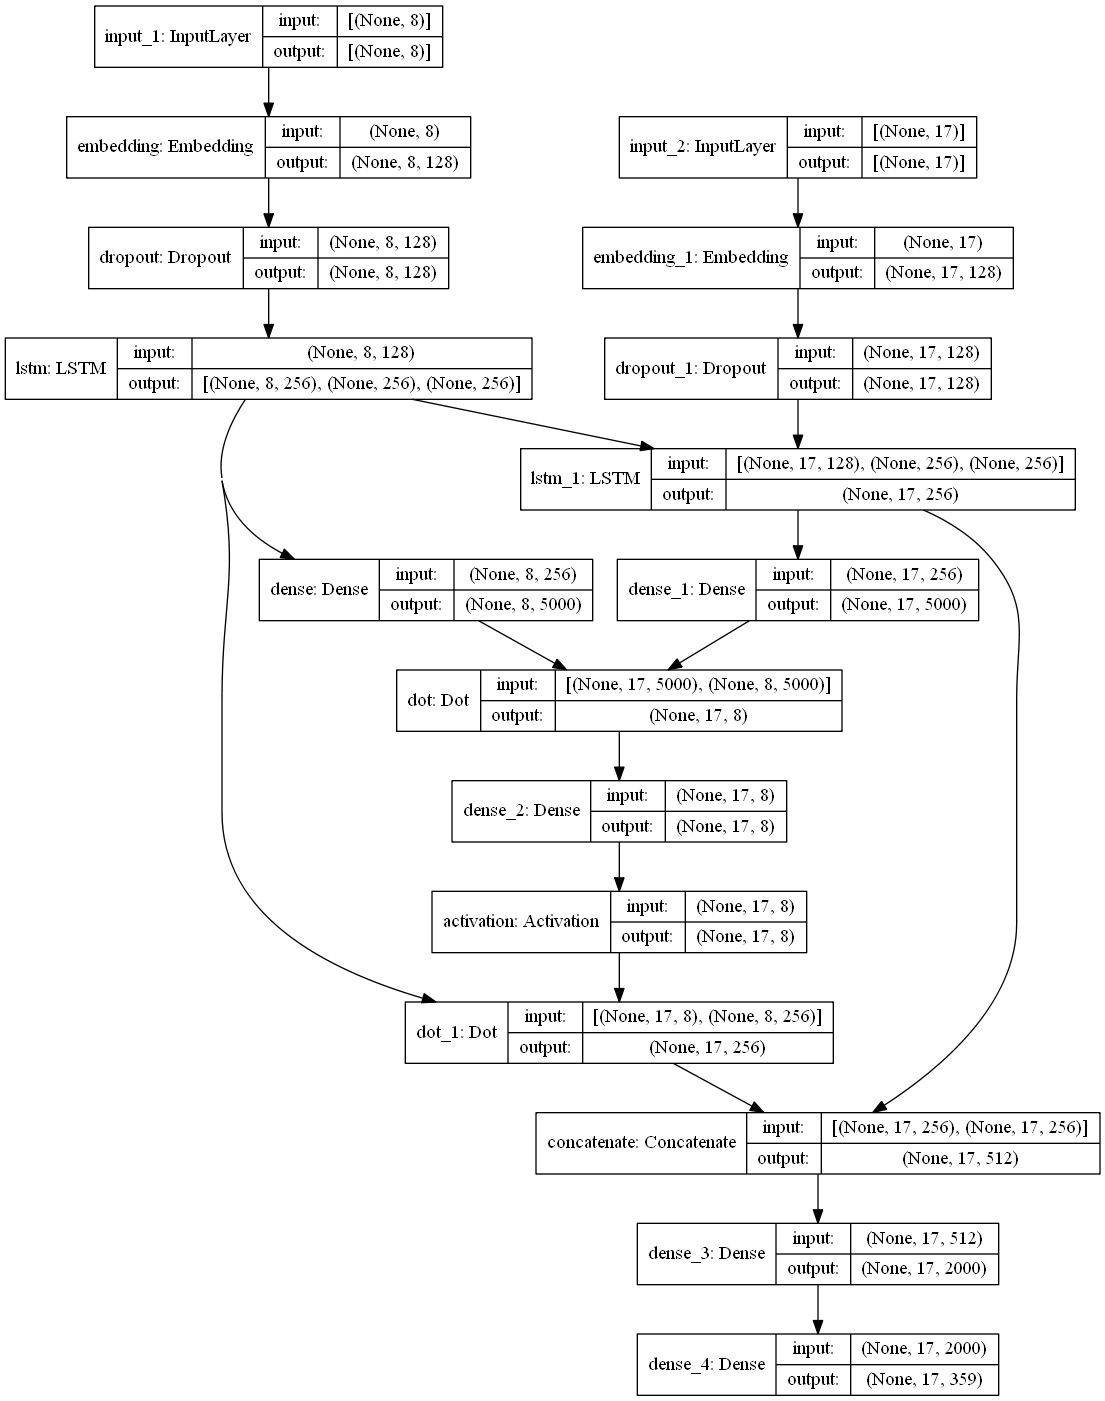

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model3, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [ ]:
history3 = model3.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=32,
          epochs=5,
          validation_split=0.05)

Epoch 1/5
1485/1485 [==============================] - 1007s 673ms/step - loss: 0.9972 - accuracy: 0.8213 - val_loss: 0.7025 - val_accuracy: 0.8316
Epoch 2/5
1485/1485 [==============================] - 253s 170ms/step - loss: 0.4625 - accuracy: 0.8853 - val_loss: 0.6088 - val_accuracy: 0.8476
Epoch 3/5
1485/1485 [==============================] - 254s 171ms/step - loss: 0.3932 - accuracy: 0.8970 - val_loss: 0.5556 - val_accuracy: 0.8585
Epoch 4/5
1485/1485 [==============================] - 258s 174ms/step - loss: 0.3526 - accuracy: 0.9048 - val_loss: 0.5615 - val_accuracy: 0.8592
Epoch 5/5
1485/1485 [==============================] - 256s 172ms/step - loss: 0.3293 - accuracy: 0.9091 - val_loss: 0.5090 - val_accuracy: 0.8688


In [ ]:
model3.layers

In [ ]:
import tensorflow as tf
act=tf.constant([[1.,2,3],[5.,6,6]])
tf.keras.activations.softmax(act).numpy()


array([[0.09003057, 0.24472848, 0.66524094],
       [0.15536241, 0.42231882, 0.42231882]], dtype=float32)

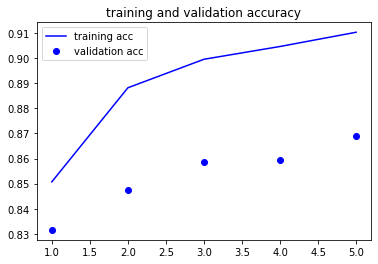

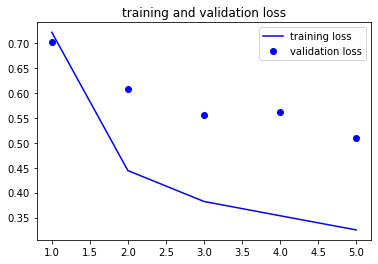

In [ ]:
import matplotlib.pyplot as plt
acc=history3.history['accuracy']
val_acc=history3.history['val_accuracy']
loss=history3.history['loss']
val_loss=history3.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'b',label='training acc')
plt.plot(epochs,val_acc,'bo',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'b',label='training loss')
plt.plot(epochs,val_loss,'bo',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

In [ ]:
decoder_input_data_pred = np.zeros(
    (len(lines.fr), fr_max_length),
    dtype='float32')

final_pred_att = []
for i in range(2500):
  word = 284
  for j in range(17):
    decoder_input_data_pred[(47500+i), j] = word
    pred = model3.predict([encoder_input_data[(47500+i)].reshape(1,8),decoder_input_data_pred[47500+i].reshape(1,17)])
    t = np.argmax(pred[0][j])
    word = t
    if word==89:
      break
  final_pred_att.append(list(decoder_input_data_pred[47500+i]))

In [ ]:
final_pred2_att = np.array(final_pred_att)
count = 0
correct_count = 0

for i in range(2500):
  correct_count += np.sum((decoder_input_data[47500+i]==final_pred2_att[i]) & (decoder_input_data[47500+i]!=89) 
                         & (decoder_input_data[47500+i]!=284))
  count += np.sum((decoder_input_data[47500+i]!=89) & (decoder_input_data[47500+i]!=284) )
correct_count/count  

0.4291672873528974

In [ ]:
decoder_input_data[47500+1]==final_pred2_att[1]

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

In [ ]:
(decoder_input_data[47500+1]==final_pred2_att[1]) & (decoder_input_data[47500+1]!=89)

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

In [ ]:
k = -2400

In [ ]:
t = model3.predict([encoder_input_data[k].reshape(1,encoder_input_data.shape[1]),decoder_input_data[k].reshape(1,decoder_input_data.shape[1])]).reshape(decoder_input_data.shape[1], num_decoder_tokens+1)

In [ ]:
for i in range(len(encoder_input_data[k])):
  if int(encoder_input_data[k][i])!=0:
    print(list(input_token_index.keys())[int(encoder_input_data[k][i]-1)])

i
feel
like
unk


In [ ]:
t2 = np.argmax(t,axis=1)
for i in range(len(t2)):
  if int(t2[i])!=0:
    print(list(target_token_index.keys())[int(t2[i]-1)])
    if int(t2[i])==89:
        break

je
unk
de
unk
unk
unk
end


In [ ]:
t2 = decoder_input_data[k]
for i in range(len(t2)):
  if int(t2[i])!=0:
    print(list(target_token_index.keys())[int(t2[i]-1)])
    if int(t2[i])==89:
        break

start
jai
unk
de
faire
la
unk
end
